In [87]:
!pip install category_encoders
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import StaleElementReferenceException
from selenium.webdriver.chromium.webdriver import ChromiumDriver
import pandas as pd
import json, time, pickle
import category_encoders as ce

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [1]:
"""
Pick the version of chrome that is supported
for 123-125:
https://googlechromelabs.github.io/chrome-for-testing/
for 122:
https://storage.googleapis.com/chrome-for-testing-public/122.0.6261.57/win64/chromedriver-win64.zip
"""

URL = 'https://racing.turfclub.com.sg/en/horse-performance/'
driver = webdriver.Chrome() #choose chrome (you can choose anything)
wait = WebDriverWait(driver, 10)  # Using explicit wait with a timeout of 10 seconds
def get_links(driver:ChromiumDriver = driver, wait:WebDriverWait=wait, *, json_file:bool = False, save_df:bool = False, verbose:bool=False) -> pd.DataFrame:
    driver.get(URL)
    horses = {}
    while True: #page traversal
        time.sleep(3) #literally wait for the browser to load
        all_links = wait.until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, '.odd td.sorting_1 a, .even td.sorting_1 a')) )#selenium gets confused when elements are finished loading due to the way singapore turf loads their content
        for link in all_links:
            try:
                horse_name = link.text.strip()
                horse_link = link.get_attribute('href')
                if horse_name:
                    horses[horse_name] = horse_link
            except StaleElementReferenceException as e:
                continue
        all_links.clear()
        if len(driver.find_elements(By.CLASS_NAME, 'paginate_button.next.disabled')) > 0: break #check if last page
        wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR, '#DataTables_Table_0_next'))).click()
    driver.delete_all_cookies()
    driver.quit() #close the driver gracefully

    if verbose:
        for horse_name, horse_links in horses.items():
            print(horse_name, horse_links)

    # Write data to JSON file
    if json_file:
        with open('horse_data.json', 'w') as json_f:
            json.dump(horses, json_f, indent=4)

    #create dataframe and save the object with pickle
    horses_df = pd.DataFrame({'Horse Name': list(horses.keys()), 'Horse Links': horses.values()})
    if save_df:
        with open('horse_data.pickle', 'wb') as f:
            pickle.dump(horses_df, f) #store the pickle file for future use

    return horses_df

if __name__ == '__main__':
    horses_df = get_links(save_df=True, json_file=True, verbose=True)

A BETTER TOMORROW https://racing.turfclub.com.sg/en/horse-performance/horse-profile/?id=47274
ACE NINE https://racing.turfclub.com.sg/en/horse-performance/horse-profile/?id=47119
ACE OF DIAMONDS https://racing.turfclub.com.sg/en/horse-performance/horse-profile/?id=47148
ACE SOVEREIGN https://racing.turfclub.com.sg/en/horse-performance/horse-profile/?id=46339
ACE'S WILD https://racing.turfclub.com.sg/en/horse-performance/horse-profile/?id=45296
ACROBAT https://racing.turfclub.com.sg/en/horse-performance/horse-profile/?id=45436
ADIRA PEGASUS https://racing.turfclub.com.sg/en/horse-performance/horse-profile/?id=46553
AFTERMATH https://racing.turfclub.com.sg/en/horse-performance/horse-profile/?id=46648
AGUERO JR https://racing.turfclub.com.sg/en/horse-performance/horse-profile/?id=46700
AHONE https://racing.turfclub.com.sg/en/horse-performance/horse-profile/?id=47061
AHORSEWITHNONAME https://racing.turfclub.com.sg/en/horse-performance/horse-profile/?id=47015
AHTIMS KLIS https://racing.turf

In [2]:
# Read the JSON file
with open('horse_data.json', 'r') as file:
    horse_data:dict = json.load(file)


In [ ]:
from selenium.webdriver.chrome.options import Options

# Configure Chrome options for headless mode
options = Options()
options.headless = True

# Set up Selenium WebDriver with Chrome
driver = webdriver.Chrome(options=options)  
wait = WebDriverWait(driver, 10)  # Using explicit wait with a timeout of 10 seconds
df_list=[]

# Define the base URL and the number of pages
for name,url in horse_data.items():
    driver.get(url)
    
    # Wait until the table is present on the page
    while True: #page traversal
        table = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.TAG_NAME, 'table'))) #dont really need it
        time.sleep(4) #literally wait for the browser to load
        all_rows = wait.until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, '.odd, .even')) )#selenium gets confused when elements are finished loading due to the way singapore turf loads their content
        for row in all_rows:
            try:
                cells = row.find_elements(By.TAG_NAME, 'td')
                if len(cells) < 18:  # Adjust the number as per your requirement
                    continue  # Skip processing this row
                row_data = {
                    'HorseName': name,
                    'Barrier': cells[8].text.strip(),
                    'CarriedWeight': cells[9].text.strip(),
                    'Distance': cells[5].text.strip(),
                    'Rating': cells[4].text.strip(),
                    'HorseWeight': cells[10].text.strip(),
                    'Going': cells[7].text.strip(),
                    'Track': cells[6].text.strip(),
                    'Jockey': cells[16].text.strip(),
                    'Trainer': cells[17].text.strip(),
                    'LBW': cells[12].text.strip(),
                }
                with open(f'horse_profiles.json', 'a') as f:
                    json.dump(row_data, f)
                    f.write('\n')
            except StaleElementReferenceException as e:
                continue
        all_rows.clear()
        if len(driver.find_elements(By.CLASS_NAME, 'paginate_button.next.disabled')) > 0: break #check if last page
        wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR, '#DataTables_Table_0_next'))).click()
# Concatenate all DataFrames in the list
df = pd.concat(df_list, ignore_index=True)
with open('horse_data.pickle', 'wb') as f:
    pickle.dump(horses_df, f) #store the pickle file for future use
# Close the WebDriver
driver.delete_all_cookies()
driver.quit()

After some trial and error, we settled upon using Length Behind Winner (LBW) as our response. We predict that the winning horse will be the horse with the lowest LBW. We originally wanted to use Finish Time instead, but found that the the data is commonly missing on Singapore Turf Club website.

However, LBW is almost always filled. 

Next, we will filter out rows with missing data. We do not need them as we are in an excess of data points (more than 40,000), and furthermore, the vast majority of rows do not have missing data. Usually, it is only the Horse Weight that might be missing. An eyeball test tells us that only about 1 in 20 rows will have a missing Horse Weight column, and as such as decided to simply remove these rows.


In [50]:
# Load JSON data from file
with open('horse_profiles.json', 'r') as f:
    json_data = json.load(f)

# Create DataFrame from JSON data
df = pd.DataFrame(json_data)

filterCols = []
# Iterate over columns and count empty strings in each column
for column in df.columns:
    empty_string_count = (df[column] == "").sum()
    print("Number of empty strings in", column, ":", empty_string_count)
    if(empty_string_count>0):
        filterCols.append(column)
        
print("\nColumns to filter",filterCols)

Number of empty strings in HorseName : 0
Number of empty strings in Barrier : 0
Number of empty strings in CarriedWeight : 431
Number of empty strings in Distance : 0
Number of empty strings in Rating : 320
Number of empty strings in HorseWeight : 641
Number of empty strings in Going : 0
Number of empty strings in Track : 0
Number of empty strings in Jockey : 2
Number of empty strings in Trainer : 0
Number of empty strings in LBW : 4

Columns to filter ['CarriedWeight', 'Rating', 'HorseWeight', 'Jockey', 'LBW']


In [117]:
#filter out rows of missing data from json
# Create a boolean mask to identify rows with empty strings in multiple columns
mask = (df['CarriedWeight'] != "") & (df['Rating'] != "") & (df['HorseWeight'] != "") & (df['Jockey'] != "") & (df['LBW'] != "")
# Filter out rows with empty strings from the DataFrame
filtered_df = df[mask]

filtered_df

,HorseName,Barrier,CarriedWeight,Distance,Rating,HorseWeight,Going,Track,Jockey,Trainer,LBW
0,A BETTER TOMORROW,4,58.0,1700,46,476,G,P,R CURATOLO,J PETERS,4.3
1,A BETTER TOMORROW,11,58.0,1600,42,483,G,T,R CURATOLO,J PETERS,2.0
2,A BETTER TOMORROW,8,55.0,1400,43,483,G,T,APP S JAMIL,J PETERS,2.3
3,A BETTER TOMORROW,8,55.0,1400,43,475,G,T,APP S JAMIL,J PETERS,2.0
4,A BETTER TOMORROW,4,57.5,1600,45,477,G,P,R WOODWORTH,J PETERS,7.6
...,...,...,...,...,...,...,...,...,...,...,...
3921,BIONICS,12,51.5,1000,56,488,G,P,APP CK NG,M WALKER,2.1
3924,BIONICS,2,54.5,1000,58,479,G,P,R MUNGER,M WALKER,6.0
3925,BIONICS,10,55.5,1000,60,481,G,P,V DURIC,M WALKER,2.9
3926,BIONICS,9,56.0,1200,61,481,G,T,I AZHAR,M WALKER,7.6


Now, we will need to convert the categorical data into numerical data so that they can be used in our Multiple Linear Regression Model. This is done through Target Encoding for Jockey, Trainer, HorseName. Label Encoding for Going and Track.

In [67]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'Going' column to encode categorical labels into numerical labels
filtered_df['encoded_Going'] = label_encoder.fit_transform(filtered_df['Going'])
filtered_df['encoded_Going'] += 1
# Display the mapping between original categorical values and encoded numerical labels
print("'Going' Mapping:")
for original_value, encoded_value in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)):
    print(f"{original_value}: {encoded_value+1}")

print("'Track' Mapping:")
filtered_df['encoded_Track'] = label_encoder.fit_transform(filtered_df['Track'])
filtered_df['encoded_Track'] += 1

# Display the mapping between original categorical values and encoded numerical labels
print("Mapping between original categorical values and encoded numerical labels:")
for original_value, encoded_value in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)):
    print(f"{original_value}: {encoded_value+1}")

'Going' Mapping:
F: 1
G: 2
H: 3
S: 4
Y: 5
'Track' Mapping:
Mapping between original categorical values and encoded numerical labels:
P: 1
T: 2


C:\Users\Wahaj\AppData\Local\Temp\ipykernel_21676\3304655186.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['encoded_Going'] = label_encoder.fit_transform(filtered_df['Going'])
C:\Users\Wahaj\AppData\Local\Temp\ipykernel_21676\3304655186.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['encoded_Going'] += 1
C:\Users\Wahaj\AppData\Local\Temp\ipykernel_21676\3304655186.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

In [79]:
# Step 2: Convert to float dtype
filtered_df['LBW'] = filtered_df['LBW'].astype(float)

# Confirm the conversion
print(filtered_df['LBW'].dtype)

float64


C:\Users\Wahaj\AppData\Local\Temp\ipykernel_21676\2591713094.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['LBW'] = filtered_df['LBW'].astype(float)


In [82]:
# Initialize the TargetEncoder
target_encoder = ce.TargetEncoder(cols=['Jockey'])

# Fit and transform the DataFrame to perform target encoding
filtered_df['encoded_Jockey'] = target_encoder.fit_transform(filtered_df['Jockey'], filtered_df['LBW'])

# Initialize the TargetEncoder
target_encoder = ce.TargetEncoder(cols=['Trainer'])

# Fit and transform the DataFrame to perform target encoding
filtered_df['encoded_Trainer'] = target_encoder.fit_transform(filtered_df['Trainer'], filtered_df['LBW'])

# Initialize the TargetEncoder
target_encoder = ce.TargetEncoder(cols=['HorseName'])

# Fit and transform the DataFrame to perform target encoding
filtered_df['encoded_HorseName'] = target_encoder.fit_transform(filtered_df['HorseName'], filtered_df['LBW'])

C:\Users\Wahaj\AppData\Local\Temp\ipykernel_21676\4211158498.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['encoded_Jockey'] = target_encoder.fit_transform(filtered_df['Jockey'], filtered_df['LBW'])
C:\Users\Wahaj\AppData\Local\Temp\ipykernel_21676\4211158498.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['encoded_Trainer'] = target_encoder.fit_transform(filtered_df['Trainer'], filtered_df['LBW'])
C:\Users\Wahaj\AppData\Local\Temp\ipykernel_21676\4211158498.py:17: Setting

In [83]:
# Display the encoded DataFrame
filtered_df

,HorseName,Barrier,CarriedWeight,Distance,Rating,HorseWeight,Going,Track,Jockey,Trainer,LBW,encoded_Going,encoded_Track,encoded_Jockey,encoded_Trainer,encoded_HorseName
0,A BETTER TOMORROW,4,58.0,1700,46,476,G,P,R CURATOLO,J PETERS,4.3,2,1,5.202980,4.909697,5.515589
1,A BETTER TOMORROW,11,58.0,1600,42,483,G,T,R CURATOLO,J PETERS,2.0,2,2,5.202980,4.909697,5.515589
2,A BETTER TOMORROW,8,55.0,1400,43,483,G,T,APP S JAMIL,J PETERS,2.3,2,2,5.227979,4.909697,5.515589
3,A BETTER TOMORROW,8,55.0,1400,43,475,G,T,APP S JAMIL,J PETERS,2.0,2,2,5.227979,4.909697,5.515589
4,A BETTER TOMORROW,4,57.5,1600,45,477,G,P,R WOODWORTH,J PETERS,7.6,2,1,4.449211,4.909697,5.515589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3921,BIONICS,12,51.5,1000,56,488,G,P,APP CK NG,M WALKER,2.1,2,1,5.305057,3.706281,5.367045
3924,BIONICS,2,54.5,1000,58,479,G,P,R MUNGER,M WALKER,6.0,2,1,5.394042,3.706281,5.367045
3925,BIONICS,10,55.5,1000,60,481,G,P,V DURIC,M WALKER,2.9,2,1,3.416688,3.706281,5.367045
3926,BIONICS,9,56.0,1200,61,481,G,T,I AZHAR,M WALKER,7.6,2,2,6.312235,3.706281,5.367045


We can now train our MLR Model using the processed data.

x_train shape : (2347, 1)
y_train shape : (2347, 1)
x_test shape : (783, 1)
y_test shape : (783, 1)
Intercept of Regression 	: b =  [4.38524333]
Coefficients of Regression 	: a =  [[0.55282335]]

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.015609880649745111
Mean Squared Error (MSE) 	: 28.2046224083758

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: -0.00131087124756335
Mean Squared Error (MSE) 	: 21.675223196042726



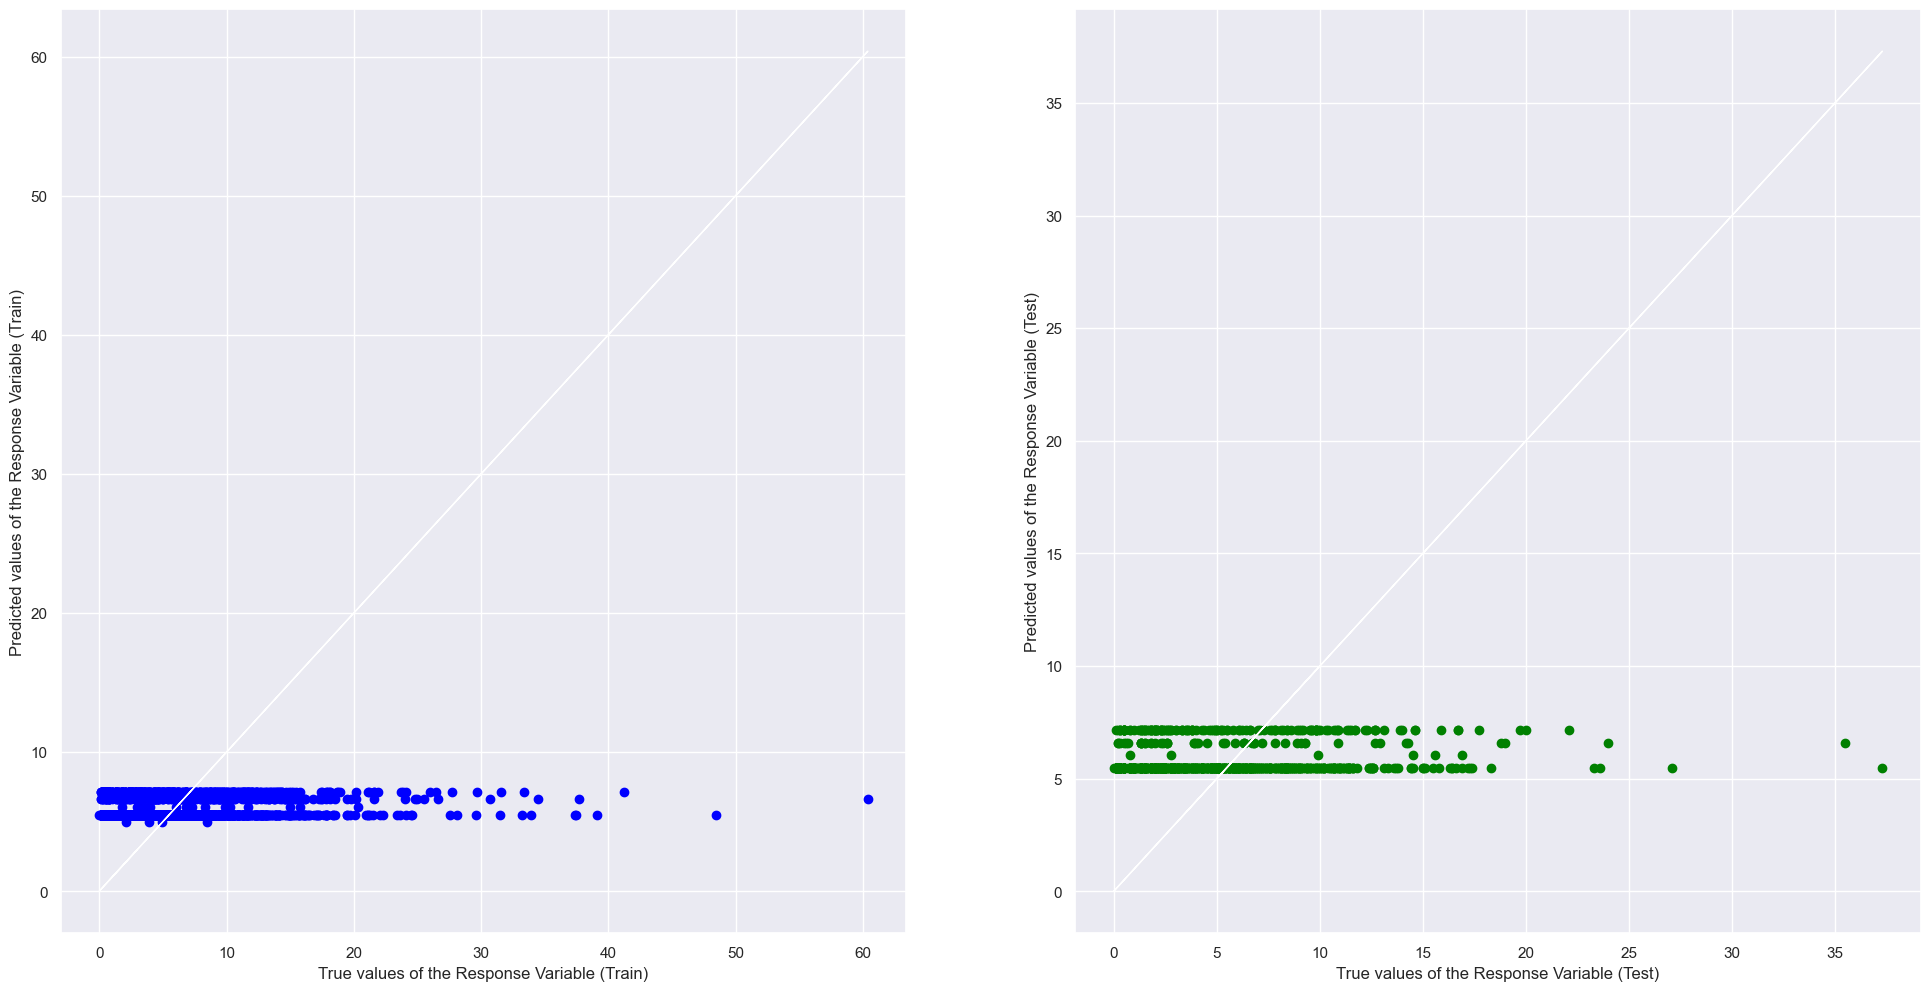

In [113]:
from sklearn import linear_model
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics

#predictors
HorseName Barrier CarriedWeightDistance Rating HorseWeight Going Track Jockey Trainer LBW	encoded_Going	encoded_Track	encoded_Jockey	encoded_Trainer	encoded_HorseName
predictors = ['encoded_Going']
X = filtered_df[predictors]

#response
y = filtered_df[['LBW']] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

print("x_train shape :", X_train.shape)
print("y_train shape :", y_train.shape)
print("x_test shape :", X_test.shape)
print("y_test shape :", y_test.shape)
# y.describe()

linreg = linear_model.LinearRegression()
linreg.fit(X_train, y_train)

#include mean squared error etc here
# Coefficients of the Linear Regression line
print('Intercept of Regression \t: b = ', linreg.intercept_)
print('Coefficients of Regression \t: a = ', linreg.coef_)
print()

# Predict Total values corresponding to HP
y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_train, y_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_test, y_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print()

# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test, y_test_pred, color = "green")
axes[1].plot(y_test, y_test, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

TypeError: Can only merge Series or DataFrame objects, a <class 'numpy.ndarray'> was passed

We can see that our model has a pretty high Mean Squared Error. This is to be expected as there is the inherent randomness of possible outcomes when it comes to horse racing.

Now that we have our model, we can now make a prediction based on the model.

In [ ]:
#predicting horse race on XYZ date

def predictTime(bar, cWeight, hWeight, dist, rating, going, track, jockey, trainer):
    predictedTime = regr.predict([[bar], [cWeight], [hWeight], [dist], [rating], [going], [track], [jockey], [trainer]])
    return predictedTime

In [126]:
filtered_df[['Distance']].describe()

,Distance
count,3130
unique,15
top,1200
freq,934
